In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text

from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
heroes = pd.read_csv('archive/hero_names.csv')
heroes.head()

name  hero_id  localized_name
0        npc_dota_hero_antimage        1       Anti-Mage
1             npc_dota_hero_axe        2             Axe
2            npc_dota_hero_bane        3            Bane
3     npc_dota_hero_bloodseeker        4     Bloodseeker
4  npc_dota_hero_crystal_maiden        5  Crystal Maiden

In [3]:
players = pd.read_csv('archive/players.csv')
players.fillna(0)
players = players[['match_id', 'account_id', 'hero_id', 'player_slot', 'gold', 'gold_per_min', 'xp_per_min', 'kills', 'deaths', 'assists', 'denies', 'hero_damage', 'hero_healing', 'level', 'leaver_status']]
players.head()

match_id  account_id  hero_id  player_slot  gold  gold_per_min  xp_per_min  \
0         0           0       86            0  3261           347         362   
1         0           1       51            1  2954           494         659   
2         0           0       83            2   110           350         385   
3         0           2       11            3  1179           599         605   
4         0           3       67            4  3307           613         762   

   kills  deaths  assists  denies  hero_damage  hero_healing  level  \
0      9       3       18       1         8690           218     16   
1     13       3       18       9        23747             0     22   
2      0       4       15       1         4217          1595     17   
3      8       4       19       6        14832          2714     21   
4     20       3       17      13        33740           243     24   

   leaver_status  
0              0  
1              0  
2              0  
3              0  
4              0

In [4]:
players['leave'] = 0
players.loc[players['leaver_status'] == 2, 'leave'] = 1
players.loc[players['leaver_status'] == 3, 'leave'] = 1
players.loc[players['leaver_status'] == 4, 'leave'] = 1

In [5]:
ratings = pd.read_csv('archive/player_ratings.csv')
ratings.head()

account_id  total_wins  total_matches  trueskill_mu  trueskill_sigma
0      236579          14             24     27.868035         5.212361
1        -343           1              1     26.544163         8.065475
2       -1217           1              1     26.521103         8.114989
3       -1227           1              1     27.248025         8.092217
4       -1284           0              1     22.931016         8.092224

In [6]:
regions = pd.read_csv('archive/cluster_regions.csv')
regions.head()

cluster   region
0      111  US WEST
1      112  US WEST
2      113  US WEST
3      121  US EAST
4      122  US EAST

In [7]:
matches = pd.read_csv('archive/match.csv')
matches = matches[['match_id', 'cluster']]
matches.head()

match_id  cluster
0         0      155
1         1      154
2         2      132
3         3      191
4         4      156

In [8]:
playerHeroes = pd.merge(players, heroes, how='inner', left_on = 'hero_id', right_on = 'hero_id')
playerHeroes.drop(columns='name', inplace=True)

In [9]:
df = pd.merge(playerHeroes, ratings, how='inner', left_on = 'account_id', right_on = 'account_id')
df = pd.merge(df, pd.merge(regions, matches, how='inner', left_on = 'cluster', right_on = 'cluster'), how='inner', left_on = 'match_id', right_on = 'match_id')
df['stay'] = 1
df.loc[df['account_id'] == 0, 'stay'] = 0
df['team'] = 0
df.loc[df['player_slot'] > 5, 'team'] = 1
bf = df[df['account_id'] != 0]
df.head()

match_id  account_id  hero_id  player_slot  gold  gold_per_min  xp_per_min  \
0         0           0       86            0  3261           347         362   
1         0           0       83            2   110           350         385   
2         0           0      102          129   317           303         369   
3         0           0        7          131   475           189         223   
4         0           1       51            1  2954           494         659   

   kills  deaths  assists  ...  leave    localized_name  total_wins  \
0      9       3       18  ...      0            Rubick     1608398   
1      0       4       15  ...      0  Treant Protector     1608398   
2      4      13        5  ...      0           Abaddon     1608398   
3      1      14        8  ...      0       Earthshaker     1608398   
4     13       3       18  ...      0         Clockwerk          14   

   total_matches  trueskill_mu  trueskill_sigma cluster     region  stay  team  
0        3315071     25.000000         8.333333     155  SINGAPORE     0     0  
1        3315071     25.000000         8.333333     155  SINGAPORE     0     0  
2        3315071     25.000000         8.333333     155  SINGAPORE     0     1  
3        3315071     25.000000         8.333333     155  SINGAPORE     0     1  
4             24     26.232905         4.854238     155  SINGAPORE     1     0  

[5 rows x 25 columns]

In [10]:
df.isnull().any()

match_id           False
account_id         False
hero_id            False
player_slot        False
gold               False
gold_per_min       False
xp_per_min         False
kills              False
deaths             False
assists            False
denies             False
hero_damage        False
hero_healing       False
level              False
leaver_status      False
leave              False
localized_name     False
total_wins         False
total_matches      False
trueskill_mu       False
trueskill_sigma    False
cluster            False
region             False
stay               False
team               False
dtype: bool

<AxesSubplot:>

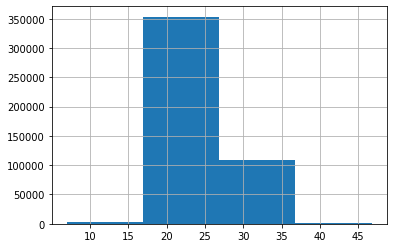

In [12]:
df['trueskill_mu'].hist(bins=4)

<AxesSubplot:>

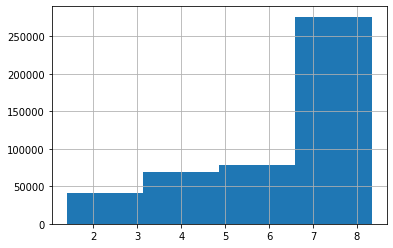

In [14]:
df['trueskill_sigma'].hist(bins=4)

In [15]:
df.groupby('stay').mean()

match_id    account_id    hero_id  player_slot         gold  \
stay                                                                    
0     24949.026904      0.000000  49.260259    65.613997  1800.868317   
1     24948.018572  59398.434576  51.468958    66.207716  1953.339621   

      gold_per_min  xp_per_min     kills    deaths    assists  ...  \
stay                                                           ...   
0       407.682726  447.708924  7.436775  8.030006  11.645295  ...   
1       421.308439  452.371650  7.400812  7.433898  11.816378  ...   

      hero_healing      level  leaver_status     leave    total_wins  \
stay                                                                   
0       428.004835  18.124259       0.044192  0.012221  1.608398e+06   
1       490.510914  18.008908       0.034558  0.007605  1.920866e+01   

      total_matches  trueskill_mu  trueskill_sigma     cluster     team  
stay                                                                     
0      3.315071e+06      25.00000         8.333333  142.335832  0.49692  
1      3.664298e+01      25.81447         5.425989  140.927610  0.50170  

[2 rows x 22 columns]

In [16]:
df.groupby('leave').mean()

match_id    account_id    hero_id  player_slot         gold  \
leave                                                                    
0      24953.209127  36344.710177  50.610085    65.960279  1908.547257   
1      24442.746061  31480.582325  50.602877    67.720484   365.785796   

       gold_per_min  xp_per_min     kills    deaths    assists  ...  \
leave                                                           ...   
0        417.468950  452.543528  7.453822  7.672920  11.804009  ...   
1        262.214661  241.358986  3.302352  6.906828   6.042019  ...   

       hero_healing      level  leaver_status     total_wins  total_matches  \
leave                                                                         
0        469.148592  18.109289        0.01425  623720.194992   1.285549e+06   
1        155.785567  12.202786        2.57319  813205.538479   1.676098e+06   

       trueskill_mu  trueskill_sigma     cluster      stay      team  
leave                                                                 
0         25.499862         6.551333  141.466568  0.612218  0.499711  
1         25.273107         7.114394  142.390500  0.494405  0.513588  

[2 rows x 22 columns]

In [17]:
df.groupby('leaver_status').mean()

match_id    account_id    hero_id  player_slot  \
leaver_status                                                       
0              24963.978047  36327.702978  50.609736    65.912365   
1              24208.278589  37521.168187  50.634276    69.274635   
2              24277.188320  30922.121879  50.277190    65.903936   
3              24712.184625  34009.176084  50.476347    69.863338   
4              24404.542510  26361.396761  52.550607    69.807692   

                      gold  gold_per_min  xp_per_min     kills    deaths  \
leaver_status                                                              
0              1924.295219    418.587029  454.184817  7.496398  7.670898   
1               819.195864    340.126825  339.008820  4.508668  7.812804   
2               429.704190    281.392298  266.725349  3.878967  7.166737   
3                20.871222    230.065703  198.344941  2.173456  6.400788   
4              1122.710526    269.530364  252.546559  4.022267  7.222672   

                 assists  ...  hero_healing      level  leave     total_wins  \
leaver_status             ...                                                  
0              11.876585  ...    472.881690  18.166874    0.0  624438.148236   
1               6.783607  ...    210.914842  14.125912    0.0  574056.412561   
2               7.321202  ...    189.637749  13.466356    1.0  872611.296234   
3               3.762812  ...     78.084757   9.883706    1.0  668944.119580   
4               6.945344  ...    233.251012  13.303644    1.0  973509.331984   

               total_matches  trueskill_mu  trueskill_sigma     cluster  \
leaver_status                                                             
0               1.287028e+06     25.499015         6.553147  141.462328   
1               1.183186e+06     25.558471         6.425823  141.759884   
2               1.798539e+06     25.218060         7.301820  144.178163   
3               1.378760e+06     25.404191         6.731906  140.109724   
4               2.006500e+06     25.132549         7.396302  140.866397   

                   stay      team  
leaver_status                      
0              0.611771  0.499339  
1              0.643096  0.525395  
2              0.457469  0.499365  
3              0.584100  0.530223  
4              0.394737  0.530364  

[5 rows x 22 columns]

In [18]:
df.groupby('team').mean()

match_id    account_id    hero_id  player_slot         gold  \
team                                                                    
0     24950.699167  36144.263026  50.503022     1.997283  1901.857461   
1     24946.120783  36453.808682  50.717082   129.997032  1886.227732   

      gold_per_min  xp_per_min     kills    deaths    assists  ...  \
team                                                           ...   
0       418.775975  451.780679  7.407303  7.672660  11.761743  ...   
1       413.241342  449.335270  7.422297  7.658773  11.737941  ...   

      hero_healing      level  leaver_status     leave     total_wins  \
team                                                                    
0       460.350843  18.068533       0.036739  0.009142  629154.583856   
1       472.058746  18.038991       0.039872  0.009659  621845.862601   

      total_matches  trueskill_mu  trueskill_sigma     cluster      stay  
team                                                                      
0      1.296749e+06     25.496566         6.568899  141.502777  0.608839  
1      1.281685e+06     25.498897         6.544344  141.447713  0.613383  

[2 rows x 22 columns]

In [19]:
from scipy.stats import ttest_ind
print('gold: ', ttest_ind(bf['gold'], df[df['account_id'] == 0]['gold']))
print('gold_per_min: ', ttest_ind(bf['gold_per_min'], df[df['account_id'] == 0]['gold_per_min']))
print('xp_per_min: ', ttest_ind(bf['xp_per_min'], df[df['account_id'] == 0]['xp_per_min']))
print('kills: ', ttest_ind(bf['kills'], df[df['account_id'] == 0]['kills']))
print('deaths: ', ttest_ind(bf['deaths'], df[df['account_id'] == 0]['deaths']))
print('assists: ', ttest_ind(bf['assists'], df[df['account_id'] == 0]['assists']))
print('denies: ', ttest_ind(bf['denies'], df[df['account_id'] == 0]['denies']))
print('hero_damage: ', ttest_ind(bf['hero_damage'], df[df['account_id'] == 0]['hero_damage']))
print('hero_healing: ', ttest_ind(bf['hero_healing'], df[df['account_id'] == 0]['hero_healing']))

gold:  Ttest_indResult(statistic=29.094556485437266, pvalue=6.182275805081904e-186)
gold_per_min:  Ttest_indResult(statistic=32.79333413095849, pvalue=1.3634458787213026e-235)
xp_per_min:  Ttest_indResult(statistic=10.59672013822142, pvalue=3.1074674444333967e-26)
kills:  Ttest_indResult(statistic=-2.201987146900172, pvalue=0.02766670462726259)
deaths:  Ttest_indResult(statistic=-52.25797798410857, pvalue=0.0)
assists:  Ttest_indResult(statistic=8.913550755542275, pvalue=4.959566898847809e-19)
denies:  Ttest_indResult(statistic=68.31598030982597, pvalue=0.0)
hero_damage:  Ttest_indResult(statistic=2.04719043512754, pvalue=0.04063994994516191)
hero_healing:  Ttest_indResult(statistic=17.19153047290371, pvalue=3.221561896486699e-66)


In [20]:
from scipy.stats import ttest_ind
print('gold: ', ttest_ind(df[df['leave'] == 0]['gold'], df[df['leave'] == 1]['gold']))
print('gold_per_min: ', ttest_ind(df[df['leave'] == 0]['gold_per_min'], df[df['leave'] == 1]['gold_per_min']))
print('xp_per_min: ', ttest_ind(df[df['leave'] == 0]['xp_per_min'], df[df['leave'] == 1]['xp_per_min']))
print('kills: ', ttest_ind(df[df['leave'] == 0]['kills'], df[df['leave'] == 1]['kills']))
print('deaths: ', ttest_ind(df[df['leave'] == 0]['deaths'], df[df['leave'] == 1]['deaths']))
print('assists: ', ttest_ind(df[df['leave'] == 0]['assists'], df[df['leave'] == 1]['assists']))
print('denies: ', ttest_ind(df[df['leave'] == 0]['denies'], df[df['leave'] == 1]['denies']))
print('hero_damage: ', ttest_ind(df[df['leave'] == 0]['hero_damage'], df[df['leave'] == 1]['hero_damage']))
print('hero_healing: ', ttest_ind(df[df['leave'] == 0]['hero_healing'], df[df['leave'] == 1]['hero_healing']))

gold:  Ttest_indResult(statistic=58.43287601218118, pvalue=0.0)
gold_per_min:  Ttest_indResult(statistic=74.31418083832251, pvalue=0.0)
xp_per_min:  Ttest_indResult(statistic=95.92505442985849, pvalue=0.0)
kills:  Ttest_indResult(statistic=50.45322516837418, pvalue=0.0)
deaths:  Ttest_indResult(statistic=13.257583958164963, pvalue=4.147180207023009e-40)
assists:  Ttest_indResult(statistic=59.64536775311154, pvalue=0.0)
denies:  Ttest_indResult(statistic=20.360381990924903, pvalue=4.120954087520137e-92)
hero_damage:  Ttest_indResult(statistic=58.425296268144734, pvalue=0.0)
hero_healing:  Ttest_indResult(statistic=17.06008695047411, pvalue=3.0788628981518285e-65)


In [21]:
df['mu_bin'] = pd.cut(df['trueskill_mu'], 4, labels=[1,2,3,4])
df['sigma_bin'] = pd.cut(df['trueskill_mu'], 4, labels=[1,2,3,4])

## Association

### Functions

In [22]:
def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate 
    k-itemsets using the frequent (k-1)-itemsets found in the previous 
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association 
           Rules", 1994.

    """
    C1 = create_candidates(dataset)
    D = list(map(set, dataset))
    F1, support_data = support_prune(D, C1, min_support, verbose=False) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1

    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is 
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return list(map(frozenset, c1))

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its 
    subsets must also be frequent. As a result, we can perform support-based 
    pruning to systematically control the exponential growth of candidate 
    itemsets. Thus, itemsets that do not meet the minimum support level are 
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent 
    (k-1)-itemsets found in the previous iteration. The candidate generation 
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2 
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

### Code

In [23]:
testA = df[['player_slot', 'match_id', 'localized_name']]
testB = testA.copy()
testB['team'] = 0
testB.loc[testB['player_slot'] > 5, 'team'] = 1
testB.loc[testB['player_slot'] == 128, 'player_slot'] = 0
testB.loc[testB['player_slot'] == 129, 'player_slot'] = 1
testB.loc[testB['player_slot'] == 130, 'player_slot'] = 2
testB.loc[testB['player_slot'] == 131, 'player_slot'] = 3
testB.loc[testB['player_slot'] == 132, 'player_slot'] = 4

In [24]:
testA.set_index(['match_id','player_slot'])['localized_name'].unstack()
testA = testA.pivot(index='match_id', columns='player_slot', values='localized_name')

In [25]:
testB.set_index(['match_id', 'team','player_slot'])['localized_name'].unstack()
testB = testB.pivot(index=['match_id','team'], columns='player_slot', values='localized_name')

In [26]:
testA.dropna(inplace=True)
len(testA)

28738

In [27]:
testB.dropna(inplace=True)
len(testB)

74672

### Match Analysis

In [28]:
d = []
dl = []
for i in range(len(testA)):
    dl.append(testA.iloc[i,:].tolist())
    d.append(set(testA.iloc[i,:].tolist()))

In [29]:
D = d

In [30]:
C1 = create_candidates(np.array(dl), verbose=False)

In [31]:
F1, support_data = support_prune(D, C1, 0.03, verbose=False)

In [32]:
F, support_data = apriori(np.array(dl), min_support=0.03, verbose=False)
# sorts the dictionary by values and returns top 10
# list({k: v for k, v in sorted(support_data.items(), reverse=True, key=lambda item: item[1])}.items())[:10]

### FP

#### Functions

In [33]:
from collections import defaultdict, namedtuple
#from itertools import imap

__author__ = 'Eric Naeseth <eric@naeseth.com>'
__copyright__ = 'Copyright © 2009 Eric Naeseth'
__license__ = 'MIT License'

def fpgrowth(dataset, min_support=0.5, include_support=True, verbose=False):
    """Implements the FP-growth algorithm.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    References
    ----------
    .. [1] J. Han, J. Pei, Y. Yin, "Mining Frequent Patterns without Candidate 
           Generation," 2000.

    """

    F = []
    support_data = {}
    for k,v in find_frequent_itemsets(dataset, min_support=min_support, include_support=include_support, verbose=verbose):
        F.append(frozenset(k))
        support_data[frozenset(k)] = v

    # Create one array with subarrays that hold all transactions of equal length.
    def bucket_list(nested_list, sort=True):
        bucket = defaultdict(list)
        for sublist in nested_list:
            bucket[len(sublist)].append(sublist)
        return [v for k,v in sorted(bucket.items())] if sort else bucket.values()

    F = bucket_list(F)
    
    return F, support_data

def find_frequent_itemsets(dataset, min_support, include_support=False, verbose=False):
    """
    Find frequent itemsets in the given transactions using FP-growth. This
    function returns a generator instead of an eagerly-populated list of items.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    """
    items = defaultdict(lambda: 0) # mapping from items to their supports
    processed_transactions = []

    # Load the passed-in transactions and count the support that individual
    # items have.
    for transaction in dataset:
        processed = []
        for item in transaction:
            items[item] += 1
            processed.append(item)
        processed_transactions.append(processed)

    # Remove infrequent items from the item support dictionary.
    items = dict((item, support) for item, support in items.items()
        if support >= min_support)

    # Build our FP-tree. Before any transactions can be added to the tree, they
    # must be stripped of infrequent items and their surviving items must be
    # sorted in decreasing order of frequency.
    def clean_transaction(transaction):
        #transaction = filter(lambda v: v in items, transaction)
        transaction.sort(key=lambda v: items[v], reverse=True)
        return transaction

    master = FPTree()
    for transaction in map(clean_transaction, processed_transactions):
        master.add(transaction)

    support_data = {}
    def find_with_suffix(tree, suffix):
        for item, nodes in tree.items():
            support = float(sum(n.count for n in nodes)) / len(dataset)
            if support >= min_support and item not in suffix:
                # New winner!
                found_set = [item] + suffix
                support_data[frozenset(found_set)] = support
                yield (found_set, support) if include_support else found_set

                # Build a conditional tree and recursively search for frequent
                # itemsets within it.
                cond_tree = conditional_tree_from_paths(tree.prefix_paths(item),
                    min_support)
                for s in find_with_suffix(cond_tree, found_set):
                    yield s # pass along the good news to our caller

    if verbose:
        # Print a list of all the frequent itemsets.
        for itemset, support in find_with_suffix(master, []):
            print("" \
                + "{" \
                + "".join(str(i) + ", " for i in iter(itemset)).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(round(support_data[frozenset(itemset)], 3)))

    # Search for frequent itemsets, and yield the results we find.
    for itemset in find_with_suffix(master, []):
        yield itemset

class FPTree(object):
    """
    An FP tree.

    This object may only store transaction items that are hashable (i.e., all
    items must be valid as dictionary keys or set members).
    """

    Route = namedtuple('Route', 'head tail')

    def __init__(self):
        # The root node of the tree.
        self._root = FPNode(self, None, None)

        # A dictionary mapping items to the head and tail of a path of
        # "neighbors" that will hit every node containing that item.
        self._routes = {}

    @property
    def root(self):
        """The root node of the tree."""
        return self._root

    def add(self, transaction):
        """
        Adds a transaction to the tree.
        """

        point = self._root

        for item in transaction:
            next_point = point.search(item)
            if next_point:
                # There is already a node in this tree for the current
                # transaction item; reuse it.
                next_point.increment()
            else:
                # Create a new point and add it as a child of the point we're
                # currently looking at.
                next_point = FPNode(self, item)
                point.add(next_point)

                # Update the route of nodes that contain this item to include
                # our new node.
                self._update_route(next_point)

            point = next_point

    def _update_route(self, point):
        """Add the given node to the route through all nodes for its item."""
        assert self is point.tree

        try:
            route = self._routes[point.item]
            route[1].neighbor = point # route[1] is the tail
            self._routes[point.item] = self.Route(route[0], point)
        except KeyError:
            # First node for this item; start a new route.
            self._routes[point.item] = self.Route(point, point)

    def items(self):
        """
        Generate one 2-tuples for each item represented in the tree. The first
        element of the tuple is the item itself, and the second element is a
        generator that will yield the nodes in the tree that belong to the item.
        """
        for item in self._routes.keys():
            yield (item, self.nodes(item))

            
    def nodes(self, item):
        """
        Generates the sequence of nodes that contain the given item.
        """

        try:
            node = self._routes[item][0]
        except KeyError:
            return

        while node:
            yield node
            node = node.neighbor

    def prefix_paths(self, item):
        """Generates the prefix paths that end with the given item."""

        def collect_path(node):
            path = []
            while node and not node.root:
                path.append(node)
                node = node.parent
            path.reverse()
            return path

        return (collect_path(node) for node in self.nodes(item))

    def inspect(self):
        print("Tree:")
        self.root.inspect(1)

        print("")
        print("Routes:")
        for item, nodes in self.items():
            print("  %r" % item)
            for node in nodes:
                print("    %r" % node)

    def _removed(self, node):
        """Called when `node` is removed from the tree; performs cleanup."""

        head, tail = self._routes[node.item]
        if node is head:
            if node is tail or not node.neighbor:
                # It was the sole node.
                del self._routes[node.item]
            else:
                self._routes[node.item] = self.Route(node.neighbor, tail)
        else:
            for n in self.nodes(node.item):
                if n.neighbor is node:
                    n.neighbor = node.neighbor # skip over
                    if node is tail:
                        self._routes[node.item] = self.Route(head, n)
                    break

def conditional_tree_from_paths(paths, min_support):
    """Builds a conditional FP-tree from the given prefix paths."""
    tree = FPTree()
    condition_item = None
    items = set()

    # Import the nodes in the paths into the new tree. Only the counts of the
    # leaf notes matter; the remaining counts will be reconstructed from the
    # leaf counts.
    for path in paths:
        if condition_item is None:
            condition_item = path[-1].item

        point = tree.root
        for node in path:
            next_point = point.search(node.item)
            if not next_point:
                # Add a new node to the tree.
                items.add(node.item)
                count = node.count if node.item == condition_item else 0
                next_point = FPNode(tree, node.item, count)
                point.add(next_point)
                tree._update_route(next_point)
            point = next_point

    assert condition_item is not None

    # Calculate the counts of the non-leaf nodes.
    for path in tree.prefix_paths(condition_item):
        count = path[-1].count
        for node in reversed(path[:-1]):
            node._count += count

    # Eliminate the nodes for any items that are no longer frequent.
    for item in items:
        support = sum(n.count for n in tree.nodes(item))
        if support < min_support:
            # Doesn't make the cut anymore
            for node in tree.nodes(item):
                if node.parent is not None:
                    node.parent.remove(node)

    # Finally, remove the nodes corresponding to the item for which this
    # conditional tree was generated.
    for node in tree.nodes(condition_item):
        if node.parent is not None: # the node might already be an orphan
            node.parent.remove(node)

    return tree

class FPNode(object):
    """A node in an FP tree."""

    def __init__(self, tree, item, count=1):
        self._tree = tree
        self._item = item
        self._count = count
        self._parent = None
        self._children = {}
        self._neighbor = None

    def add(self, child):
        """Adds the given FPNode `child` as a child of this node."""

        if not isinstance(child, FPNode):
            raise TypeError("Can only add other FPNodes as children")

        if not child.item in self._children:
            self._children[child.item] = child
            child.parent = self

    def search(self, item):
        """
        Checks to see if this node contains a child node for the given item.
        If so, that node is returned; otherwise, `None` is returned.
        """

        try:
            return self._children[item]
        except KeyError:
            return None

    def remove(self, child):
        try:
            if self._children[child.item] is child:
                del self._children[child.item]
                child.parent = None
                self._tree._removed(child)
                for sub_child in child.children:
                    try:
                        # Merger case: we already have a child for that item, so
                        # add the sub-child's count to our child's count.
                        self._children[sub_child.item]._count += sub_child.count
                        sub_child.parent = None # it's an orphan now
                    except KeyError:
                        # Turns out we don't actually have a child, so just add
                        # the sub-child as our own child.
                        self.add(sub_child)
                child._children = {}
            else:
                raise ValueError("that node is not a child of this node")
        except KeyError:
            raise ValueError("that node is not a child of this node")

    def __contains__(self, item):
        return item in self._children

    @property
    def tree(self):
        """The tree in which this node appears."""
        return self._tree

    @property
    def item(self):
        """The item contained in this node."""
        return self._item

    @property
    def count(self):
        """The count associated with this node's item."""
        return self._count

    def increment(self):
        """Increments the count associated with this node's item."""
        if self._count is None:
            raise ValueError("Root nodes have no associated count.")
        self._count += 1

    @property
    def root(self):
        """True if this node is the root of a tree; false if otherwise."""
        return self._item is None and self._count is None

    @property
    def leaf(self):
        """True if this node is a leaf in the tree; false if otherwise."""
        return len(self._children) == 0

    def parent():
        doc = "The node's parent."
        def fget(self):
            return self._parent
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a parent.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a parent from another tree.")
            self._parent = value
        return locals()
    parent = property(**parent())

    def neighbor():
        doc = """
        The node's neighbor; the one with the same value that is "to the right"
        of it in the tree.
        """
        def fget(self):
            return self._neighbor
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a neighbor.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a neighbor from another tree.")
            self._neighbor = value
        return locals()
    neighbor = property(**neighbor())

    @property
    def children(self):
        """The nodes that are children of this node."""
        return tuple(self._children.values())
        
    def inspect(self, depth=0):
        print(('  ' * depth) + repr(self))
        for child in self.children:
            child.inspect(depth + 1)

    def __repr__(self):
        if self.root:
            return "<%s (root)>" % type(self).__name__
        return "<%s %r (%r)>" % (type(self).__name__, self.item, self.count)

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1,  support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([item]) for item in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

In [34]:
F, support_data = fpgrowth(np.array(dl), min_support=0.01, verbose=False)

In [35]:
H = generate_rules(F, support_data, min_confidence=0.2, verbose=False)

In [36]:
def Sort_Tuple(tup):  
        
    lst = len(tup)  
    for i in range(0, lst):  
            
        for j in range(0, lst-i-1):  
            if (tup[j][-1] > tup[j + 1][-1]):  
                temp = tup[j]  
                tup[j]= tup[j + 1]  
                tup[j + 1]= temp  
    return tup
          
confH = Sort_Tuple(H)[::-1]

print(confH[:5])

[(frozenset({'Slardar', 'Spectre'}), frozenset({'Windranger'}), 0.4416107382550336), (frozenset({'Slardar', 'Lich'}), frozenset({'Windranger'}), 0.4413875598086124), (frozenset({'Shadow Demon'}), frozenset({'Windranger'}), 0.44027303754266206), (frozenset({'Anti-Mage', 'Winter Wyvern'}), frozenset({'Windranger'}), 0.43654266958424504), (frozenset({'Bounty Hunter', 'Anti-Mage'}), frozenset({'Windranger'}), 0.4361233480176212)]


In [37]:
i = 1
for x in confH:
    print(x)
    if i >= 5:
        break
    i += 1

(frozenset({'Slardar', 'Spectre'}), frozenset({'Windranger'}), 0.4416107382550336)
(frozenset({'Slardar', 'Lich'}), frozenset({'Windranger'}), 0.4413875598086124)
(frozenset({'Shadow Demon'}), frozenset({'Windranger'}), 0.44027303754266206)
(frozenset({'Anti-Mage', 'Winter Wyvern'}), frozenset({'Windranger'}), 0.43654266958424504)
(frozenset({'Bounty Hunter', 'Anti-Mage'}), frozenset({'Windranger'}), 0.4361233480176212)


In [38]:
support = []
dups = []
for x in H:
    lst = list(x)
    l = set()
    for y in lst[:-1]:
        l.add(list(y)[0])

    # print(l, support_data[frozenset(l)])
    if (l, support_data[frozenset(l)]) not in support:
        support.append((l, support_data[frozenset(l)]))
    else:
        dups.append((l, support_data[frozenset(l)]))
support.sort(key=lambda x:x[1], reverse=True)

In [39]:
support[:5]

[({'Shadow Fiend', 'Windranger'}, 0.1312547846057485),
 ({'Slardar', 'Windranger'}, 0.09875426264875774),
 ({'Earthshaker', 'Windranger'}, 0.09008977660240797),
 ({'Shadow Fiend', 'Slardar'}, 0.08765397731226947),
 ({'Tusk', 'Windranger'}, 0.08744519451597188)]

## Decision Tree

In [40]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text

from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

### mu

In [41]:
x = df.drop(columns=['match_id', 'account_id', 'hero_id', 'player_slot', 'localized_name','cluster', 'region', 'team', 'stay', 'total_wins', 'total_matches', 'trueskill_mu', 'trueskill_sigma', 'mu_bin', 'sigma_bin', 'leaver_status', 'leave'])
y = df["mu_bin"]

In [42]:
X_train, test_x, y_train, test_y = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [43]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  67
Training Score:  1.0 Test Score:  0.6217138686549222
Number of Leaves:  70768 Feature Importances: 
[0.1700444  0.14474814 0.14961509 0.07151634 0.06057221 0.08309011
 0.0521177  0.16530853 0.05343677 0.04955071]



In [44]:
clf = DecisionTreeClassifier(random_state = 42, max_depth=5)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  5
Training Score:  0.7588181176975681 Test Score:  0.7576670435193268
Number of Leaves:  32 Feature Importances: 
[0.00472083 0.17860602 0.03238515 0.00829522 0.17961894 0.01299292
 0.37670895 0.02106915 0.09639334 0.0892095 ]



In [45]:
x.head()

gold  gold_per_min  xp_per_min  kills  deaths  assists  denies  \
0  3261           347         362      9       3       18       1   
1   110           350         385      0       4       15       1   
2   317           303         369      4      13        5       2   
3   475           189         223      1      14        8       0   
4  2954           494         659     13       3       18       9   

   hero_damage  hero_healing  level  
0         8690           218     16  
1         4217          1595     17  
2        15028           764     16  
3         4774             0     12  
4        23747             0     22

In [46]:
# for i in reversed(range(1, 40)):
#     clf = DecisionTreeClassifier(max_depth = i, random_state = 42)
#     clf.fit(X_train, y_train)
#     train = clf.score(X_train, y_train)
#     test = clf.score(test_x, test_y)
#     print('Max Depth: ', clf.get_depth())
#     print('Training Score: ', train, 'Test Score: ', test)
#     print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
#     print(clf.feature_importances_)
#     print()

### Sigma

In [47]:
x = df.drop(columns=['match_id', 'account_id', 'hero_id', 'player_slot', 'localized_name','cluster', 'region', 'team', 'stay', 'total_wins', 'total_matches', 'trueskill_mu', 'trueskill_sigma', 'mu_bin', 'sigma_bin', 'leaver_status'])
y = df["sigma_bin"]

In [48]:
X_train, test_x, y_train, test_y = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [49]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  64
Training Score:  1.0 Test Score:  0.6222290596333557
Number of Leaves:  70701 Feature Importances: 
[0.16980806 0.14419618 0.14781792 0.0712137  0.05936863 0.08257973
 0.05282247 0.16828669 0.05278571 0.04997023 0.00115068]



In [50]:
clf = DecisionTreeClassifier(random_state = 42, max_depth=5)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  5
Training Score:  0.7588181176975681 Test Score:  0.7576670435193268
Number of Leaves:  32 Feature Importances: 
[0.00468159 0.17712135 0.03478141 0.00822626 0.17812585 0.01288492
 0.37357755 0.01411648 0.07845248 0.09357435 0.02445777]



In [51]:
# for i in reversed(range(1, 40)):
#     clf = DecisionTreeClassifier(max_depth = i, random_state = 42)
#     clf.fit(X_train, y_train)
#     train = clf.score(X_train, y_train)
#     test = clf.score(test_x, test_y)
#     print('Max Depth: ', clf.get_depth())
#     print('Training Score: ', train, 'Test Score: ', test)
#     print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
#     print(clf.feature_importances_)
#     print()

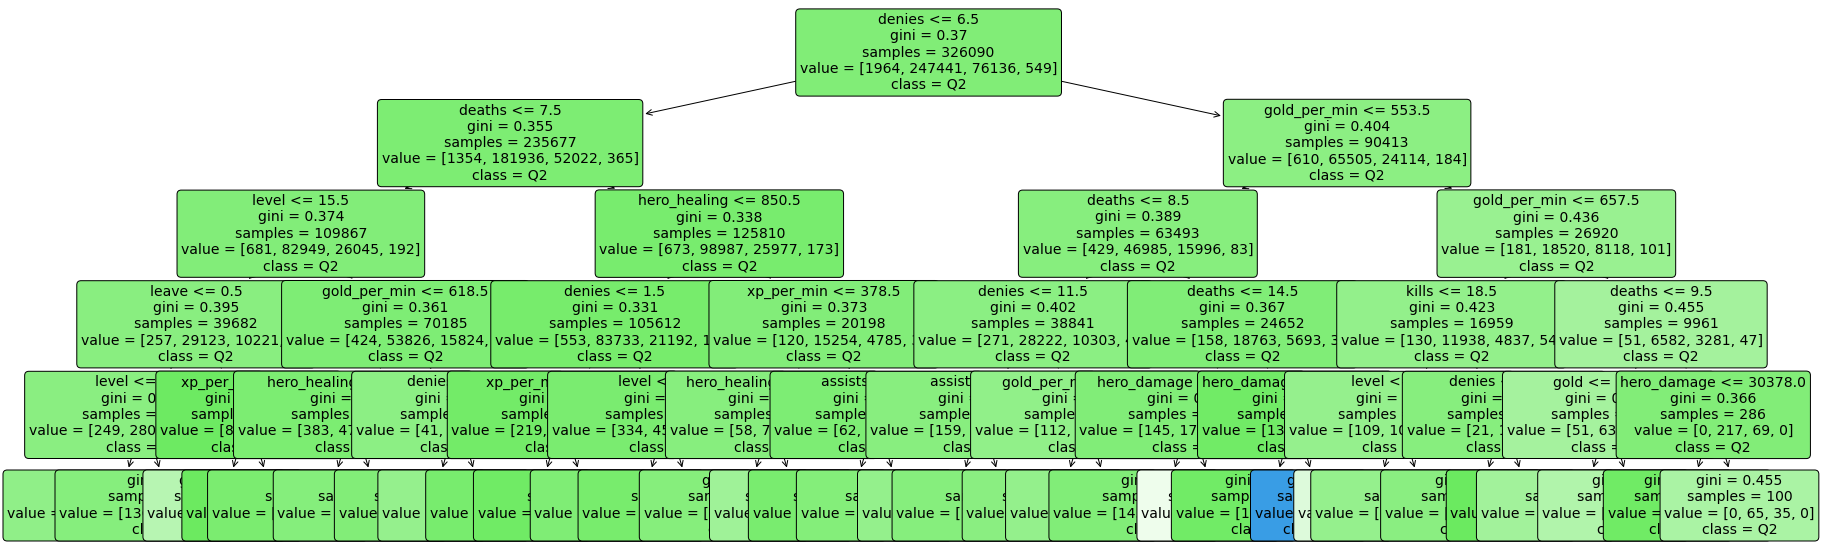

In [52]:
clf = DecisionTreeClassifier(max_depth = 5, random_state = 42)
clf.fit(X_train, y_train)
#plt the figure, setting a black background
plt.figure(figsize=(30,10), facecolor ='w')
#create the tree plot
a = tree.plot_tree(clf,
                   #use the feature names stored
                   feature_names = x.columns,
                   #use the class names stored
                   class_names = ['Q1', 'Q2', 'Q3', 'Q4'],
                   rounded = True,
                   filled = True,
                   fontsize=14)
#show the plot
plt.show()

### Stay

In [53]:
x = df.drop(columns=['match_id', 'account_id', 'hero_id', 'player_slot', 'localized_name','cluster', 'region', 'team', 'stay', 'total_wins', 'total_matches', 'trueskill_mu', 'trueskill_sigma', 'mu_bin', 'sigma_bin', 'leave', 'leaver_status'])
y = df["stay"]

In [54]:
X_train, test_x, y_train, test_y = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [55]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  56
Training Score:  1.0 Test Score:  0.5361563890836756
Number of Leaves:  81223 Feature Importances: 
[0.16585109 0.14593648 0.14948426 0.07470016 0.06053611 0.08115638
 0.04614478 0.1672135  0.05296385 0.0560134 ]



In [56]:
# for i in reversed(range(1, 56)):
#     clf = DecisionTreeClassifier(max_depth = i, random_state = 42)
#     clf.fit(X_train, y_train)
#     train = clf.score(X_train, y_train)
#     test = clf.score(test_x, test_y)
#     print('Max Depth: ', clf.get_depth())
#     print('Training Score: ', train, 'Test Score: ', test)
#     print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
#     print(clf.feature_importances_)
#     print()

In [57]:
clf = DecisionTreeClassifier(random_state = 42, max_depth=6)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  6
Training Score:  0.6146125302830507 Test Score:  0.6156389083675602
Number of Leaves:  64 Feature Importances: 
[0.01625801 0.02844027 0.07514479 0.         0.15888705 0.0919079
 0.53657526 0.02512881 0.01132047 0.05633744]



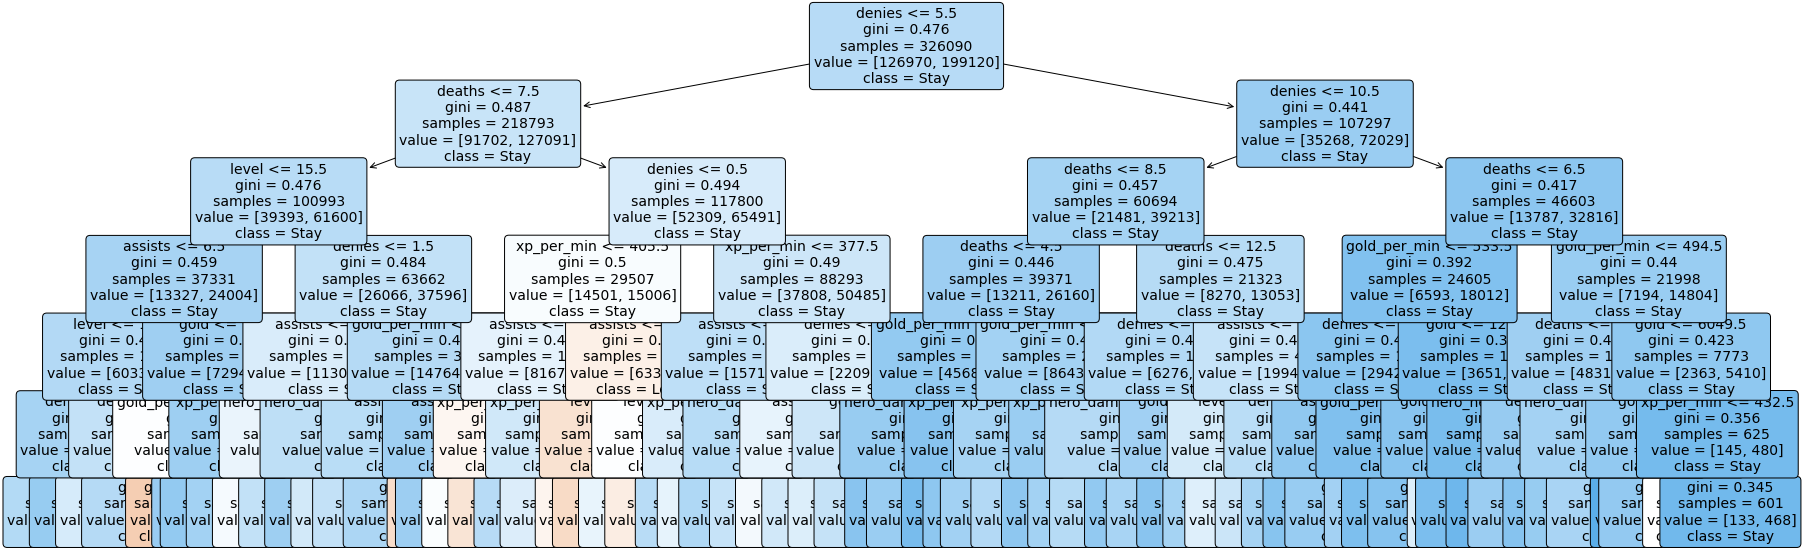

In [58]:
clf = DecisionTreeClassifier(max_depth = 6, random_state = 42)
clf.fit(X_train, y_train)
#plt the figure, setting a black background
plt.figure(figsize=(30,10), facecolor ='w')
#create the tree plot
a = tree.plot_tree(clf,
                   #use the feature names stored
                   feature_names = x.columns,
                   #use the class names stored
                   class_names = ['Leave', 'Stay'],
                   rounded = True,
                   filled = True,
                   fontsize=14)
#show the plot
plt.show()

### Status

In [59]:
x = df.drop(columns=['match_id', 'account_id', 'hero_id', 'player_slot', 'localized_name','cluster', 'region', 'team', 'stay', 'total_wins', 'total_matches', 'trueskill_mu', 'trueskill_sigma', 'mu_bin', 'sigma_bin', 'leave', 'leaver_status'])
y = df["leaver_status"]

In [60]:
X_train, test_x, y_train, test_y = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [61]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  50
Training Score:  0.9999969333619553 Test Score:  0.9680510039068649
Number of Leaves:  9007 Feature Importances: 
[0.43914928 0.0944293  0.09251337 0.03795894 0.05154526 0.04129124
 0.04664842 0.11388143 0.03314714 0.04943563]



In [62]:
# for i in reversed(range(1, 30)):
#     clf = DecisionTreeClassifier(max_depth = i, random_state = 42)
#     clf.fit(X_train, y_train)
#     train = clf.score(X_train, y_train)
#     test = clf.score(test_x, test_y)
#     print('Max Depth: ', clf.get_depth())
#     print('Training Score: ', train, 'Test Score: ', test)
#     print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
#     print(clf.feature_importances_)
#     print()

In [63]:
clf = DecisionTreeClassifier(random_state = 42, max_depth=6)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  6
Training Score:  0.9832070900671593 Test Score:  0.9821400460809708
Number of Leaves:  60 Feature Importances: 
[9.20117058e-01 2.38517371e-02 1.55239441e-02 1.58113923e-03
 4.38987641e-03 7.66946080e-03 1.42565089e-04 2.08522083e-03
 3.50244041e-04 2.42887545e-02]



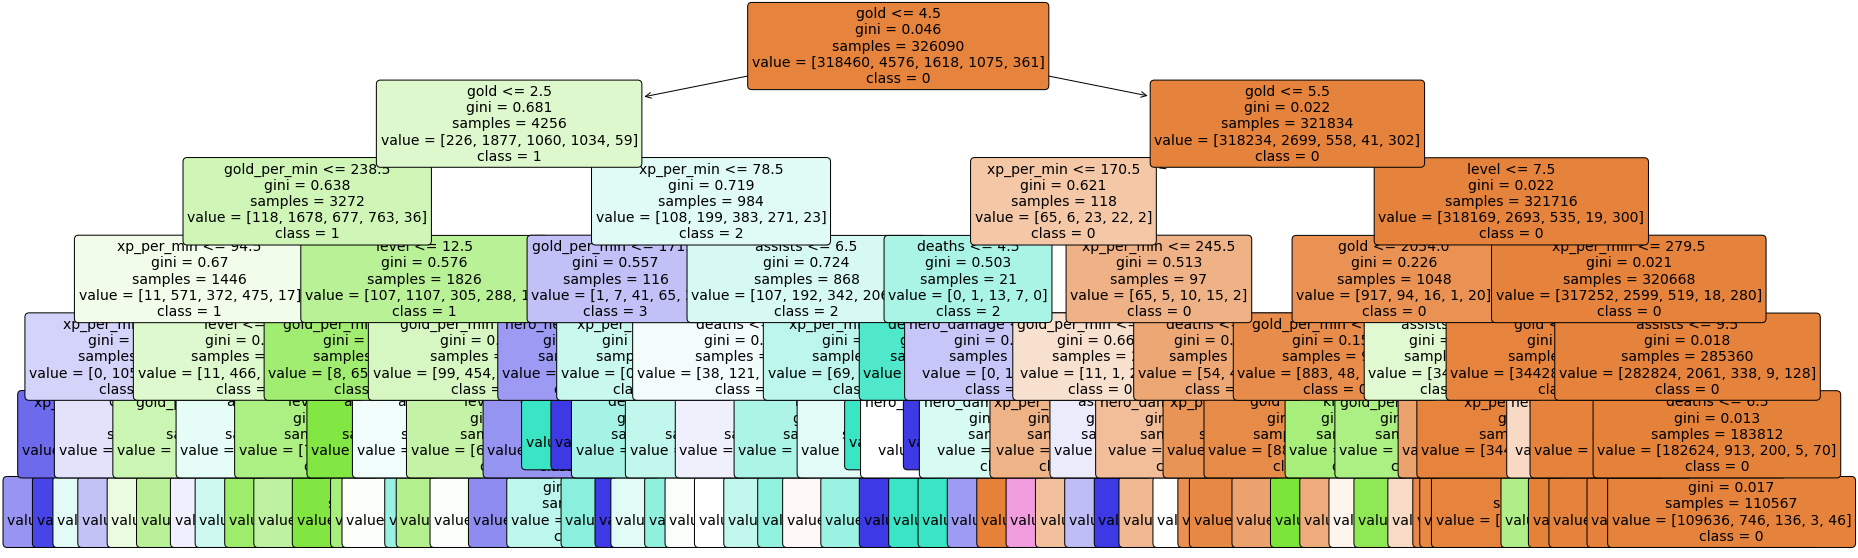

In [64]:
clf = DecisionTreeClassifier(max_depth = 6, random_state = 42)
clf.fit(X_train, y_train)
#plt the figure, setting a black background
plt.figure(figsize=(30,10), facecolor ='w')
#create the tree plot
a = tree.plot_tree(clf,
                   #use the feature names stored
                   feature_names = x.columns,
                   #use the class names stored
                   class_names = ['0','1','2','3','4','5','6'],
                   rounded = True,
                   filled = True,
                   fontsize=14)
#show the plot
plt.show()

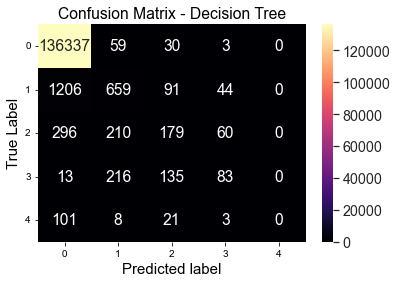

<Figure size 720x504 with 0 Axes>

In [65]:
test_pred_decision_tree = clf.predict(test_x)
#get the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_y,  
                                            test_pred_decision_tree)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize =15)
# ax.set_xticklabels(['']+labels)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(['0','1','2','3','4'], rotation = 0)
plt.show()

### Leave

In [66]:
x = df.drop(columns=['match_id', 'account_id', 'hero_id', 'player_slot', 'localized_name','cluster', 'region', 'team', 'stay', 'total_wins', 'total_matches', 'trueskill_mu', 'trueskill_sigma', 'mu_bin', 'sigma_bin', 'leave', 'leaver_status'])
y = df["leave"]

In [67]:
X_train, test_x, y_train, test_y = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [68]:
clf = DecisionTreeClassifier(random_state = 42)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  34
Training Score:  1.0 Test Score:  0.9886801093349743
Number of Leaves:  2971 Feature Importances: 
[0.43496684 0.1154963  0.09714021 0.03504039 0.04636621 0.04900602
 0.04453715 0.10822572 0.02139042 0.04783073]



In [69]:
# for i in reversed(range(1, 34)):
#     clf = DecisionTreeClassifier(max_depth = i, random_state = 42)
#     clf.fit(X_train, y_train)
#     train = clf.score(X_train, y_train)
#     test = clf.score(test_x, test_y)
#     print('Max Depth: ', clf.get_depth())
#     print('Training Score: ', train, 'Test Score: ', test)
#     print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
#     print(clf.feature_importances_)
#     print()

In [70]:
clf = DecisionTreeClassifier(random_state = 42, max_depth=7)
clf.fit(X_train, y_train)

print('Max Depth: ', clf.get_depth())
print('Training Score: ', clf.score(X_train, y_train), 'Test Score: ', clf.score(test_x, test_y))
print('Number of Leaves: ', clf.get_n_leaves(), 'Feature Importances: ')
print(clf.feature_importances_)
print()

Max Depth:  7
Training Score:  0.9937103253702966 Test Score:  0.9930735435121714
Number of Leaves:  105 Feature Importances: 
[0.7977691  0.07207692 0.04349728 0.00601541 0.00853717 0.00660776
 0.00941537 0.00981136 0.00087897 0.04539067]



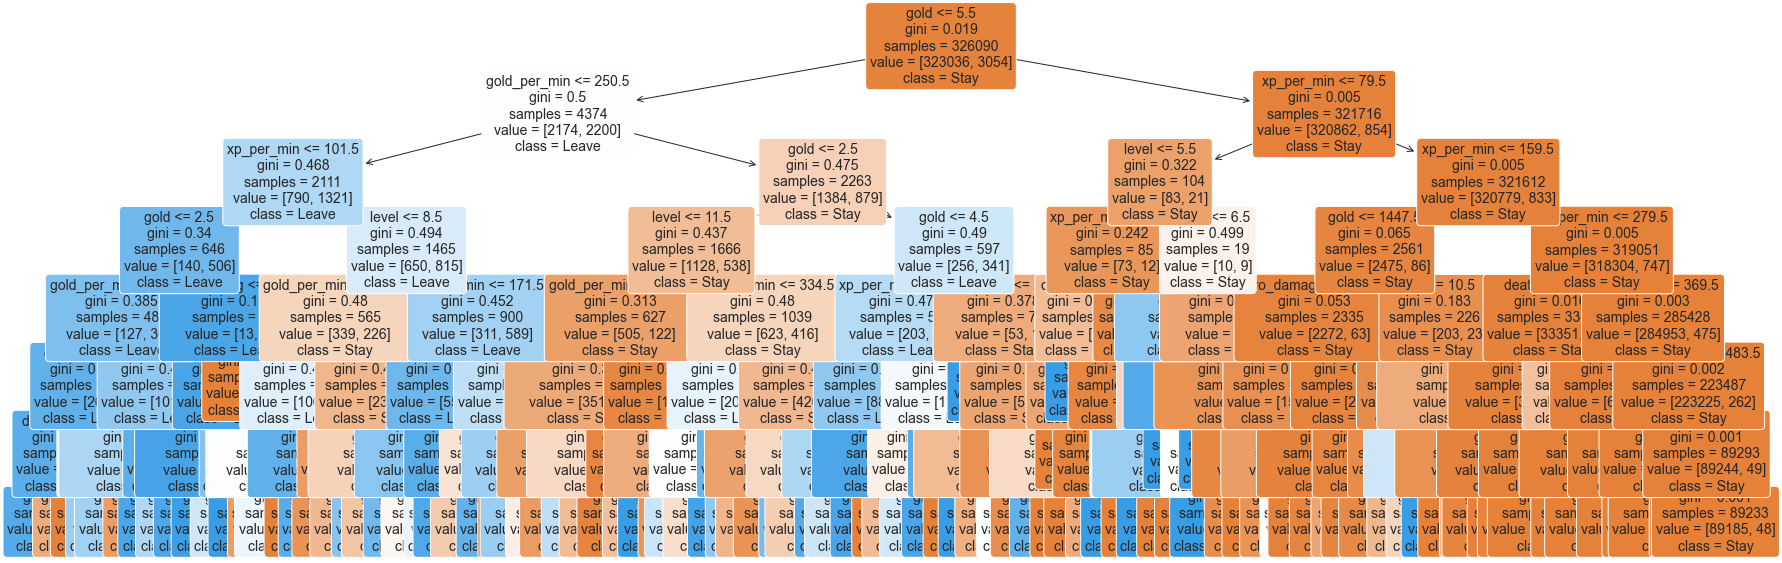

In [71]:
clf = DecisionTreeClassifier(max_depth = 7, random_state = 42)
clf.fit(X_train, y_train)
#plt the figure, setting a black background
plt.figure(figsize=(30,10), facecolor ='w')
#create the tree plot
a = tree.plot_tree(clf,
                   #use the feature names stored
                   feature_names = x.columns,
                   #use the class names stored
                   class_names = ['Stay', 'Leave'],
                   rounded = True,
                   filled = True,
                   fontsize=14)
#show the plot
plt.show()

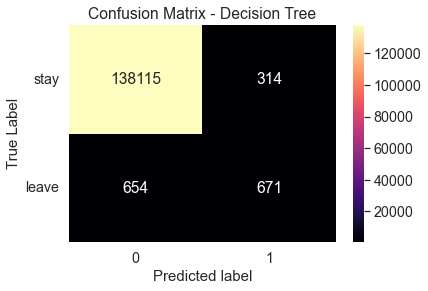

<Figure size 720x504 with 0 Axes>

In [72]:
test_pred_decision_tree = clf.predict(test_x)
#get the confusion matrix
confusion_matrix = metrics.confusion_matrix(test_y,  
                                            test_pred_decision_tree)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize =15)
# ax.set_xticklabels(['']+labels)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(['stay', 'leave'], rotation = 0)
plt.show()

## Linear Regression

In [73]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [74]:
x = df.drop(columns=['match_id', 'account_id', 'hero_id', 'player_slot', 'localized_name','cluster', 'region', 'team', 'stay', 'total_wins', 'total_matches', 'trueskill_mu', 'trueskill_sigma', 'mu_bin', 'sigma_bin'])
y = df['trueskill_mu']
X_train, test_x, y_train, test_y = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [75]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(test_x)

In [76]:
regr.score(test_x, test_y)

0.0036545430731829143

In [77]:
# Split into a training and testing set
X_train, X_test, y_train, test_y = train_test_split(x, y, random_state=42)

# Define the pipeline for scaling and model fitting
pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()),
    ("Linear Regression", linear_model.LinearRegression())
])

# Scale the data and fit the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print('Mean Absolute Error: ', mean_absolute_error(y_pred, test_y))
print('Score', pipeline.score(X_test, test_y))

Mean Absolute Error:  1.964669725588323
Score 0.0035632551383004696


In [78]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(test_y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_y, y_pred))

Mean squared error: 8.45
Coefficient of determination: 0.00


### Plots

Feature:  gold
Mean squared error: 8.42
Coefficient of determination: 0.00


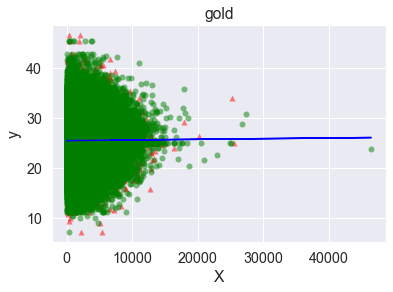

Feature:  gold_per_min
Mean squared error: 8.41
Coefficient of determination: 0.00


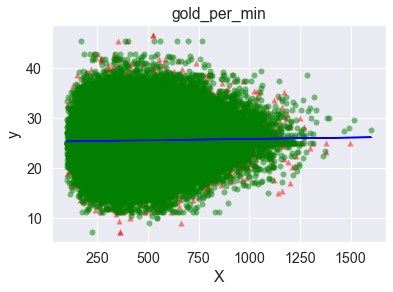

Feature:  xp_per_min
Mean squared error: 8.42
Coefficient of determination: 0.00


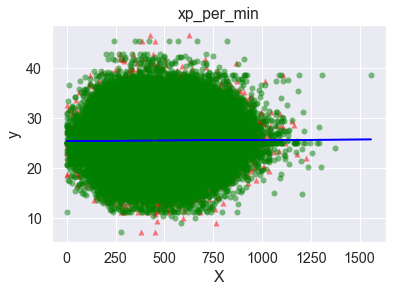

Feature:  kills
Mean squared error: 8.42
Coefficient of determination: 0.00


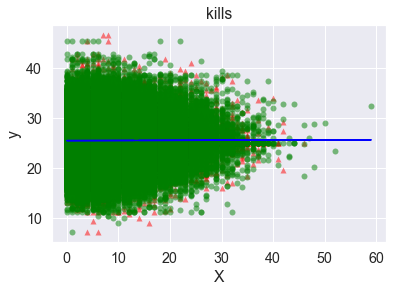

Feature:  deaths
Mean squared error: 8.41
Coefficient of determination: 0.00


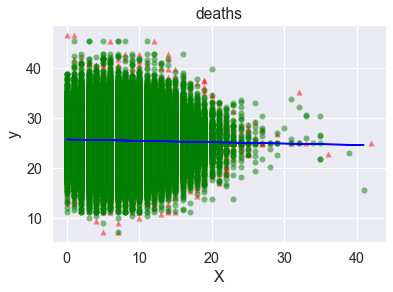

Feature:  assists
Mean squared error: 8.42
Coefficient of determination: -0.00


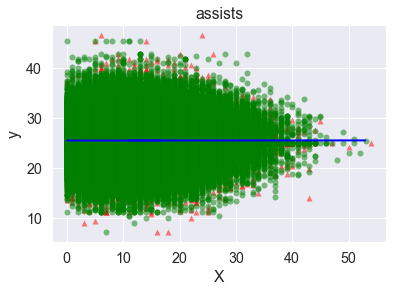

Feature:  denies
Mean squared error: 8.41
Coefficient of determination: 0.00


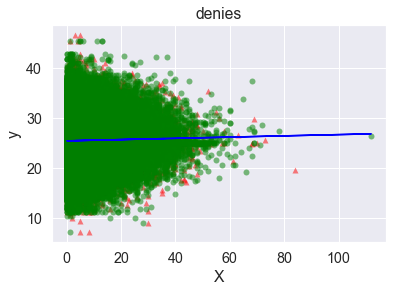

Feature:  hero_damage
Mean squared error: 8.42
Coefficient of determination: 0.00


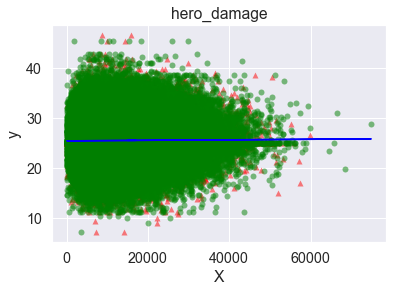

Feature:  hero_healing
Mean squared error: 8.42
Coefficient of determination: 0.00


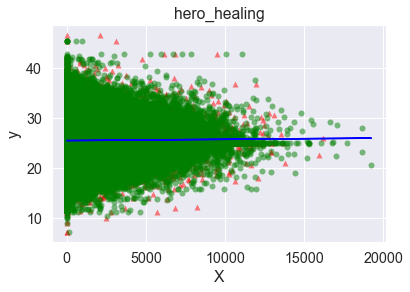

Feature:  level
Mean squared error: 8.42
Coefficient of determination: 0.00


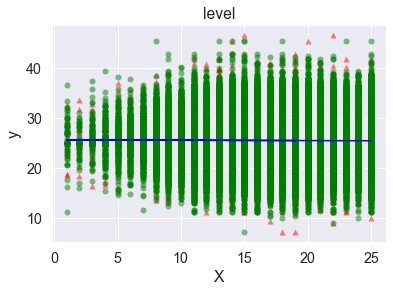

Feature:  leaver_status
Mean squared error: 8.42
Coefficient of determination: 0.00


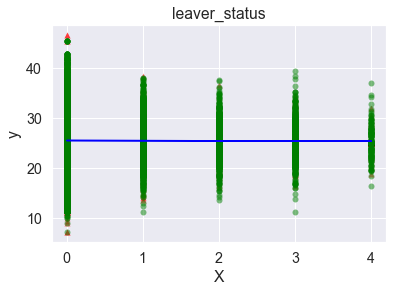

Feature:  leave
Mean squared error: 8.42
Coefficient of determination: 0.00


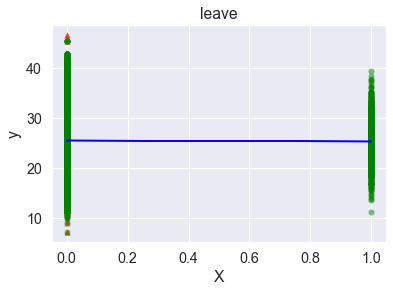

In [79]:
for i in range(x.shape[1]):
    X_train, X_test, y_train, y_test = train_test_split(x.iloc[:,i].values.reshape(-1,1), y, test_size=0.8, random_state=42)
    # reg = linear_model.LinearRegression().fit(X_train, y_train)
    pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()),
    ("Linear Regression", linear_model.LinearRegression())
])

    reg = pipeline.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    # The Feature name
    print('Feature: ', x.iloc[:,i].name)
    # The coefficients
    # print("Coefficients: \n", reg.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

    plt.plot(X_test, y_pred, color="blue")
    plt.scatter(X_train, y_train, color="red", alpha = .5, linewidths=.001, marker='^')
    plt.scatter(X_test, y_test, color="green", alpha = .5, linewidths=.001)


    # plt.xticks(())
    # plt.yticks(())
    plt.xlabel('X')
    plt.ylabel('y')
    # plt.legend(loc='best')

    plt.title(x.iloc[:,i].name)
    plt.show()

## Logistic Regression

In [80]:
x = df.drop(columns=['match_id', 'account_id', 'hero_id', 'player_slot', 'localized_name','cluster', 'region', 'team', 'stay', 'total_wins', 'total_matches', 'trueskill_mu', 'trueskill_sigma', 'mu_bin', 'sigma_bin', 'leave', 'leaver_status'])
y = df["mu_bin"]

X_train, test_x, y_train, test_y = train_test_split(x,y,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [81]:
logr = linear_model.LogisticRegression()
logr.fit(X_train, y_train)

c:\ALICE_Env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [82]:
logr.score(test_x, test_y)

0.7572305622737096

In [83]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

### Mu

In [84]:
# Split into a training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=42)

# Define the pipeline for scaling and model fitting
pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()),
    ("Logistic Regression", linear_model.LogisticRegression())
])

# Scale the data and fit the model
pipeline.fit(X_train, Y_train)

# Evaluate the model
Y_pred = pipeline.predict(X_test)
print('Mean Absolute Error: ', mean_absolute_error(Y_pred, Y_test))
print('Score', pipeline.score(X_test, Y_test))

Mean Absolute Error:  0.24371248744214802
Score 0.7578502674715141


c:\ALICE_Env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
print('Score', pipeline.score(X_train, Y_train))

Score 0.758651680247751


### Sigma

In [86]:
# Split into a training and testing set
y = df["sigma_bin"]
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=42)

# Define the pipeline for scaling and model fitting
pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()),
    ("Logistic Regression", linear_model.LogisticRegression())
])

# Scale the data and fit the model
pipeline.fit(X_train, Y_train)

# Evaluate the model
Y_pred = pipeline.predict(X_test)
print('Mean Absolute Error: ', mean_absolute_error(Y_pred, Y_test))
print('Score', pipeline.score(X_test, Y_test))

Mean Absolute Error:  0.24371248744214802
Score 0.7578502674715141


c:\ALICE_Env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
print('Score', pipeline.score(X_train, Y_train))

Score 0.758651680247751


### Stay

In [88]:
# Split into a training and testing set
y = df["stay"]
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=42)

# Define the pipeline for scaling and model fitting
pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()),
    ("Logistic Regression", linear_model.LogisticRegression())
])

# Scale the data and fit the model
pipeline.fit(X_train, Y_train)

# Evaluate the model
Y_pred = pipeline.predict(X_test)
print('Mean Absolute Error: ', mean_absolute_error(Y_pred, Y_test))
print('Score', pipeline.score(X_test, Y_test))

Mean Absolute Error:  0.38462661320098573
Score 0.6153733867990142


In [89]:
print('Score', pipeline.score(X_train, Y_train))

Score 0.6148524684944602


### Leave

In [90]:
# Split into a training and testing set
y = df["leave"]
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=42)

# Define the pipeline for scaling and model fitting
pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()),
    ("Logistic Regression", linear_model.LogisticRegression())
])

# Scale the data and fit the model
pipeline.fit(X_train, Y_train)

# Evaluate the model
Y_pred = pipeline.predict(X_test)
print('Mean Absolute Error: ', mean_absolute_error(Y_pred, Y_test))
print('Score', pipeline.score(X_test, Y_test))

Mean Absolute Error:  0.008397661019568783
Score 0.9916023389804313


In [91]:
print('Score', pipeline.score(X_train, Y_train))

Score 0.9916595827501624


### Status

In [92]:
# Split into a training and testing set
y = df["leaver_status"]
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=42)

# Define the pipeline for scaling and model fitting
pipeline = Pipeline([
    ("Standard Scaling", StandardScaler()),
    ("Logistic Regression", linear_model.LogisticRegression())
])

# Scale the data and fit the model
pipeline.fit(X_train, Y_train)

# Evaluate the model
Y_pred = pipeline.predict(X_test)
print('Mean Absolute Error: ', mean_absolute_error(Y_pred, Y_test))
print('Score', pipeline.score(X_test, Y_test))

Mean Absolute Error:  0.03602064210336507
Score 0.9769364851752947


c:\ALICE_Env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
print('Score', pipeline.score(X_train, Y_train))

Score 0.9771397005578405


## PCA

In [94]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

### Stay

In [95]:
y = df['stay']
scaler = StandardScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)

pca = PCA(n_components=2)
pca.fit(X_scaled)
xpca = pca.transform(X_scaled)

print(pca.explained_variance_ratio_*100)

[44.21475457 14.52720259]


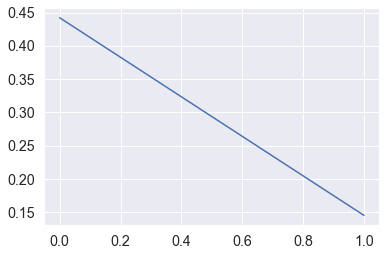

In [96]:
plt.plot(pca.explained_variance_ratio_)

<AxesSubplot:>

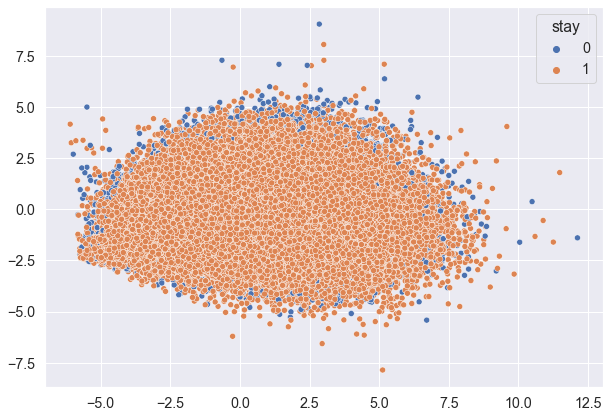

In [97]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=xpca[:,0], y=xpca[:,1], hue=y)

### Leave

In [98]:
y = df['leave']
scaler = StandardScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)

pca = PCA(n_components=2)
pca.fit(X_scaled)
xpca = pca.transform(X_scaled)

print(pca.explained_variance_ratio_*100)

[44.21475457 14.52720259]


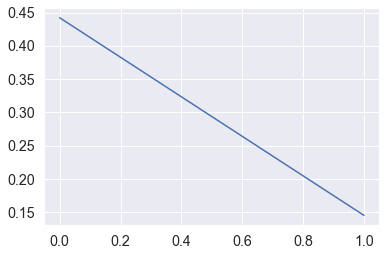

In [99]:
plt.plot(pca.explained_variance_ratio_)

<AxesSubplot:>

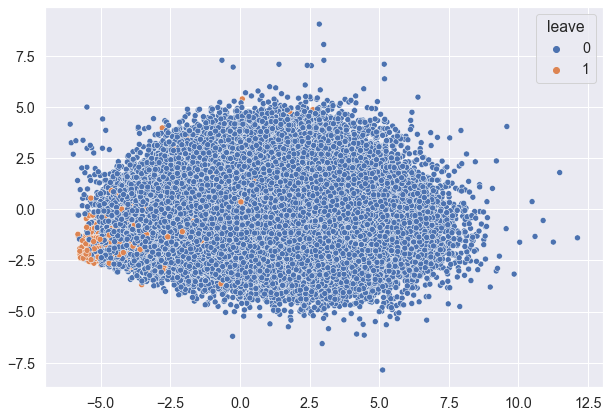

In [100]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=xpca[:,0], y=xpca[:,1], hue=y)

### Status

In [101]:
y = df['leaver_status']
scaler = StandardScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)

pca = PCA(n_components=2)
pca.fit(X_scaled)
xpca = pca.transform(X_scaled)

print(pca.explained_variance_ratio_*100)

[44.21475457 14.52720259]


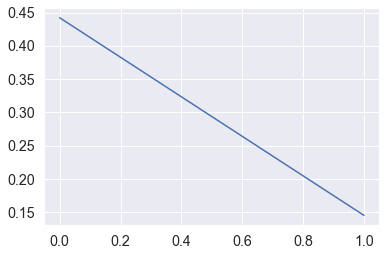

In [102]:
plt.plot(pca.explained_variance_ratio_)

<AxesSubplot:>

c:\ALICE_Env\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


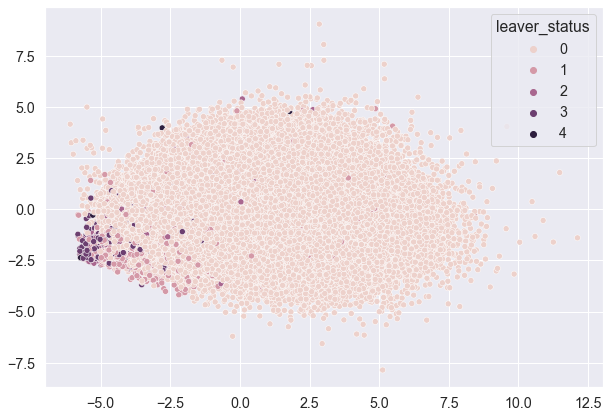

In [103]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=xpca[:,0], y=xpca[:,1], hue=y)

### Mu

<AxesSubplot:>

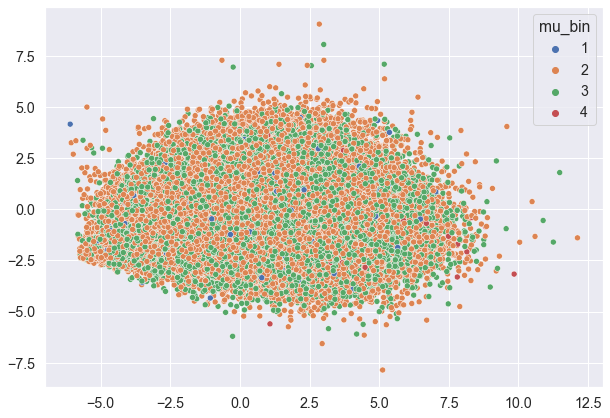

In [104]:
y = df["mu_bin"]
plt.figure(figsize=(10,7))
sns.scatterplot(x=xpca[:,0], y=xpca[:,1], hue=y)

<AxesSubplot:>

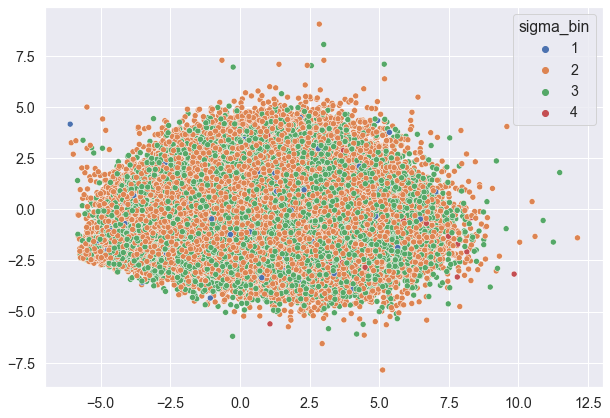

In [105]:
y = df["sigma_bin"]
plt.figure(figsize=(10,7))
sns.scatterplot(x=xpca[:,0], y=xpca[:,1], hue=y)

<AxesSubplot:>

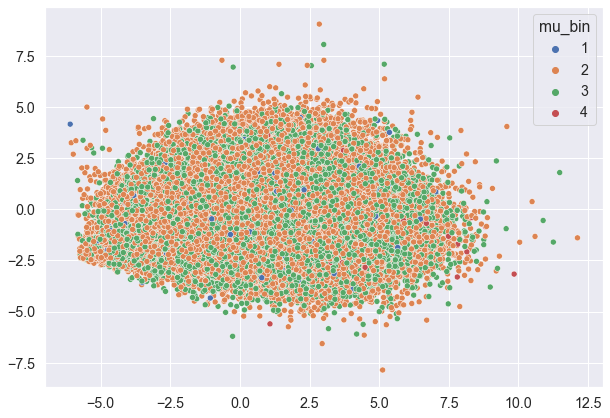

In [106]:
y = df["mu_bin"]
plt.figure(figsize=(10,7))
sns.scatterplot(x=xpca[:,0], y=xpca[:,1], hue=y)

In [107]:
df.head()

match_id  account_id  hero_id  player_slot  gold  gold_per_min  xp_per_min  \
0         0           0       86            0  3261           347         362   
1         0           0       83            2   110           350         385   
2         0           0      102          129   317           303         369   
3         0           0        7          131   475           189         223   
4         0           1       51            1  2954           494         659   

   kills  deaths  assists  ...  total_wins  total_matches  trueskill_mu  \
0      9       3       18  ...     1608398        3315071     25.000000   
1      0       4       15  ...     1608398        3315071     25.000000   
2      4      13        5  ...     1608398        3315071     25.000000   
3      1      14        8  ...     1608398        3315071     25.000000   
4     13       3       18  ...          14             24     26.232905   

   trueskill_sigma  cluster     region stay  team  mu_bin  sigma_bin  
0         8.333333      155  SINGAPORE    0     0       2          2  
1         8.333333      155  SINGAPORE    0     0       2          2  
2         8.333333      155  SINGAPORE    0     1       2          2  
3         8.333333      155  SINGAPORE    0     1       2          2  
4         4.854238      155  SINGAPORE    1     0       2          2  

[5 rows x 27 columns]

<AxesSubplot:xlabel='region'>

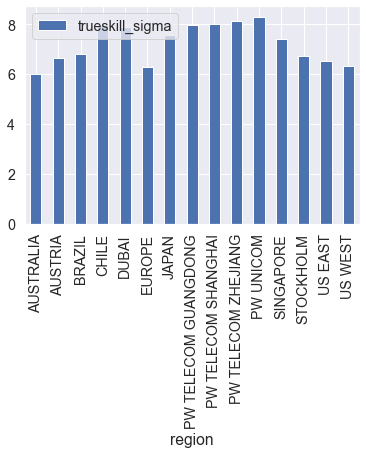

In [108]:
df.groupby('region')['trueskill_sigma'].mean().plot(legend=True, kind='bar')